In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader


In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f"Using Pytorch v{torch.__version__}, Device: {DEVICE}")

Using Pytorch v2.0.0, Device: cuda


In [4]:
cifar = datasets.CIFAR10(root="./CIFAR_10", train=True, download=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13847460.93it/s]


Extracting ./CIFAR_10/cifar-10-python.tar.gz to ./CIFAR_10


In [5]:
print(cifar[0])

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7A8DAD187F40>, 6)


## Visualize the 5th element of the cifar10 train dataset with its label.
- hint 1: Use plt.imshow() func to visualize the image.
- hint 2: Use CIFAR10_LABEL to extract the label. With the given label index in the dataset, you can extract the label.

In [6]:
CIFAR10_LABEL = ['airplane','automobile','bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

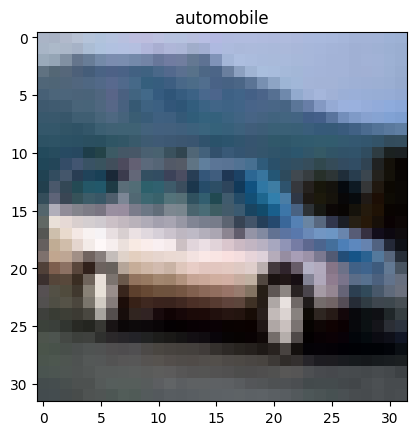

In [7]:
plt.imshow(cifar[4][0])
plt.title(CIFAR10_LABEL[cifar.targets[4]])


def plot_image(image: PIL.Image.Image, label: str):
    
    plt.title(label)
    plt.axis('off')

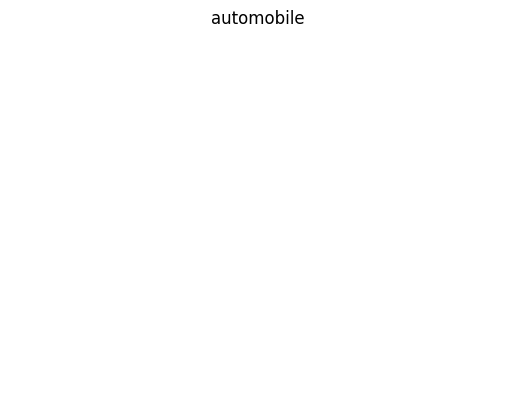

In [8]:
for i in range(5):
    plot_image(cifar[i][0], CIFAR10_LABEL[cifar.targets[i]])

## Custom Dataset

In [9]:
'''
CIFAR10 데이터셋 커스터 마이징
'''
class CustomDataset(Dataset):
    def __init__(self, train, data_dir='./CIFAR_10_Custom'):
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


In [10]:
train_dataset = CustomDataset(train=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13548894.42it/s]


Extracting ./CIFAR_10_Custom/cifar-10-python.tar.gz to ./CIFAR_10_Custom


In [11]:
test_dataset = CustomDataset(train=False)

Files already downloaded and verified


<Image no.0>
torch.Size([3, 32, 32])
frog
<Image no.1>
torch.Size([3, 32, 32])
truck
<Image no.2>
torch.Size([3, 32, 32])
truck
<Image no.3>
torch.Size([3, 32, 32])
deer


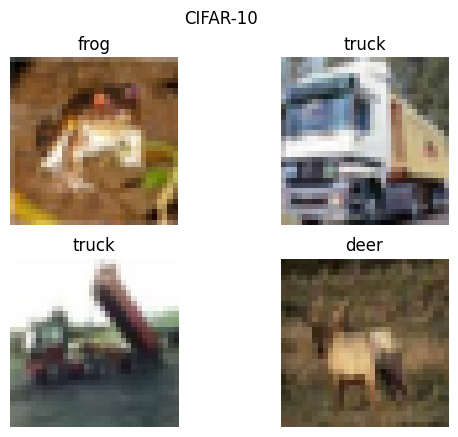

In [12]:
fig = plt.figure()
plt.suptitle('CIFAR-10')
for i in range(4):
    print(f"<Image no.{i}>")
    
    image, label_idx = train_dataset[i]
    label = CIFAR10_LABEL[label_idx]
    
    plt.subplot(2,2,i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    
    toTensor = transforms.ToTensor()
    image = toTensor(image)
    
    
    print(image.shape)
    
    print(label)

## Collate_fn

In [13]:
def collate_fn(data_samples: list[tuple[PIL.Image.Image, int]])-> tuple:
    batch_x, batch_y = [], []
    toTensor = transforms.ToTensor()
#     images, labels = zip(*data_samples)
#     batch_x = [toTensor(x) for x in images]
#     batch_y = labels
    for i, (img, label) in enumerate(data_samples):
        # img : (H, W, C)
        # toTensor(img) -> (C, H, W)
        batch_x.append(toTensor(img))
        batch_y.append(torch.Tensor([label]))
    batch_x = torch.stack(batch_x).float()
    batch_y = torch.tensor(batch_y).long()
    
    return batch_x, batch_y

In [14]:
batch_size = 8
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )

In [15]:
image, label = next(iter(train_loader))

print(image.shape)
print(label.shape)
print(image, label)

torch.Size([8, 3, 32, 32])
torch.Size([8])
tensor([[[[0.9608, 0.9647, 0.9647,  ..., 0.9412, 0.9490, 0.9490],
          [0.9529, 0.9490, 0.9490,  ..., 0.9686, 0.9647, 0.9059],
          [0.9569, 0.9490, 0.9608,  ..., 0.9020, 0.9608, 0.8706],
          ...,
          [0.7294, 0.7333, 0.6902,  ..., 0.6980, 0.7529, 0.7608],
          [0.6824, 0.7333, 0.6824,  ..., 0.8196, 0.8471, 0.8314],
          [0.7020, 0.7373, 0.7373,  ..., 0.8235, 0.8078, 0.8000]],

         [[0.9255, 0.9412, 0.9412,  ..., 0.9412, 0.9451, 0.9216],
          [0.9490, 0.9686, 0.9725,  ..., 0.9569, 0.9529, 0.8824],
          [0.9490, 0.9686, 0.9608,  ..., 0.8431, 0.9647, 0.8627],
          ...,
          [0.6706, 0.6902, 0.6549,  ..., 0.6706, 0.7216, 0.7098],
          [0.6235, 0.6902, 0.6235,  ..., 0.7569, 0.7843, 0.7725],
          [0.6471, 0.7020, 0.6824,  ..., 0.7725, 0.7608, 0.7333]],

         [[0.9020, 0.9098, 0.8941,  ..., 0.9059, 0.9020, 0.8588],
          [0.9333, 0.9725, 0.9373,  ..., 0.9294, 0.9137, 0.8118],

## Transforms (Data Augmentation)

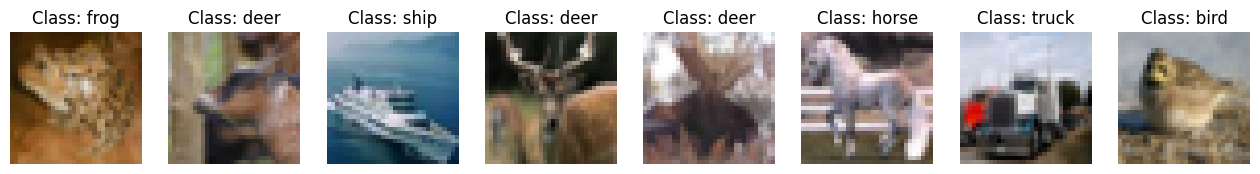

In [16]:
def visualize_batch(batch, augment=None):
    images, labels = batch
    batch_size = images.shape[0]
    pltsize = 2
    plt.figure(figsize=(batch_size * pltsize, pltsize))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        plt.axis('off')
        plt.imshow(np.transpose(augment(images[i]) if augment else images[i], (1, 2, 0)))
        plt.title('Class: ' + str(CIFAR10_LABEL[labels[i].item()]))
    
sample_batch = next(iter(train_loader))
visualize_batch(sample_batch)

## Apply Data augmentation usuing torchvision.transforms Module

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

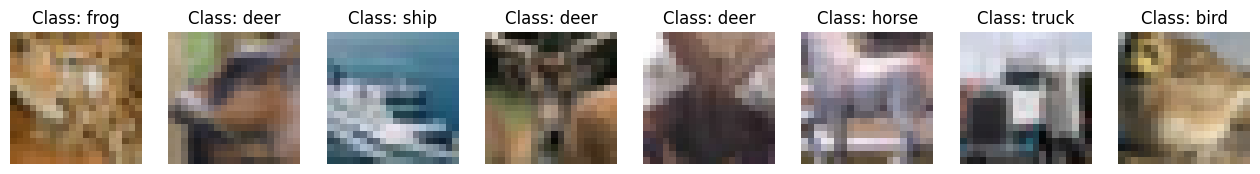

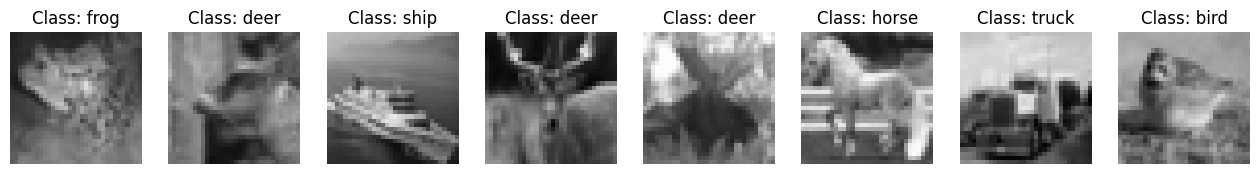

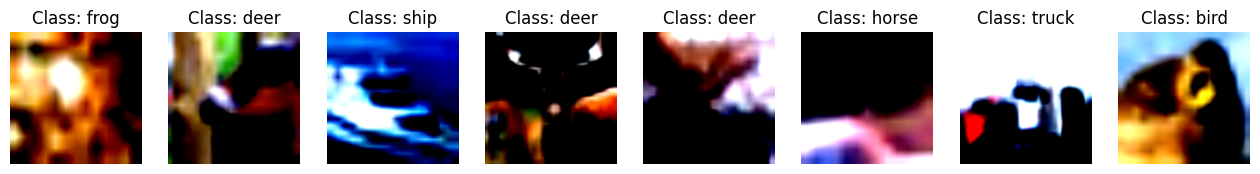

In [17]:
from torchvision.transforms import v2

visualize_batch(sample_batch, augment=transforms.CenterCrop(20))
visualize_batch(sample_batch, augment=transforms.Grayscale(num_output_channels=3))

t = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

visualize_batch(sample_batch, augment=t)




In [18]:
augment_pool = [
    v2.Grayscale(num_output_channels=3),
    v2.functional.hflip,
    v2.functional.vflip,
]

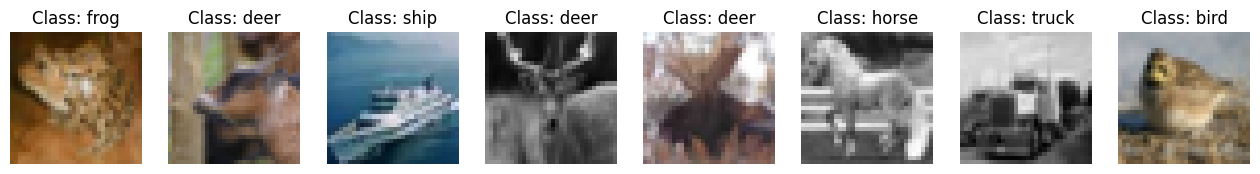

In [19]:
class RandomAugmentation:
    def __init__(self, augment_pool, prob=0.5):
        self.augment_pool = augment_pool
        self.prob = prob
        
    def __call__(self, image):
        import random
        augmenting = random.choices([True, False], weights=[self.prob, 1 - self.prob])[0]
        if augmenting:
            selected_aug = random.choice(self.augment_pool)
            image = selected_aug(image)
        return image
    
visualize_batch(sample_batch, augment=RandomAugmentation(augment_pool, 0.8))

In [20]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [21]:
class CustomDataset(Dataset):
    def __init__(self, train, transform=None, data_dir='./CIFAR_10'):
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def collate_fn(self, data_samples: PIL.Image.Image):
        batch_x, batch_y = [], []
        toTensor = v2.toTensor()
        for x, y in data_samples:
            img_tensor = toTensor(self.transform(x))
            if self.transform:
                image_tensor = self.transform(image)
            batch_x.append(img_tensor)
            batch_y.append(torch.Tensor([y]))
        
        batch_x, batch_y = torch.stack(batch_x).float(), torch.cat(batch_y).long()
        return batch_x, batch_y


In [22]:
train_dataset = CustomDataset(train=True, transform=RandomAugmentation(augment_pool, 0.5))
test_dataset = CustomDataset(train=False, transform=RandomAugmentation(augment_pool, 0.5))

Files already downloaded and verified
Files already downloaded and verified


In [23]:
batch_size = 8
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )

In [24]:
sample_batch = next(iter(train_loader))

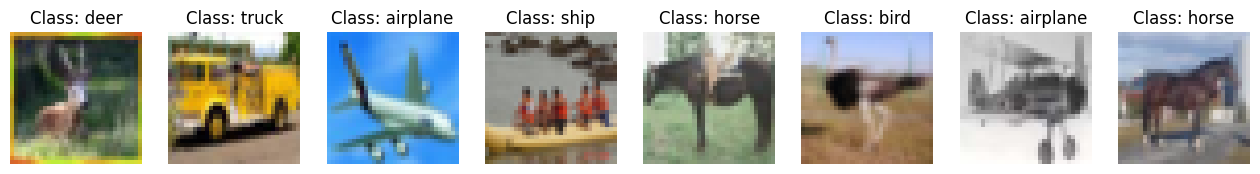

In [25]:
visualize_batch(sample_batch)